In [1]:
import tensorflow as tf
import numpy as np # math computations
import matplotlib.pyplot as plt # Plotting bar chart
import tensorflow_datasets as tfds

In [2]:
# Get dataset and information from the Tensorflow datasets
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised = True, shuffle_files = True, split=['train'])

In [3]:
# Check out the dataset and the info
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

# Data Preparation

In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO): 
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))
    test_dataset = val_test_dataset.skip(int(TEST_RATIO * DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset

In [5]:
# Partition 
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Dataset Visualization

2025-06-16 14:55:32.702352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


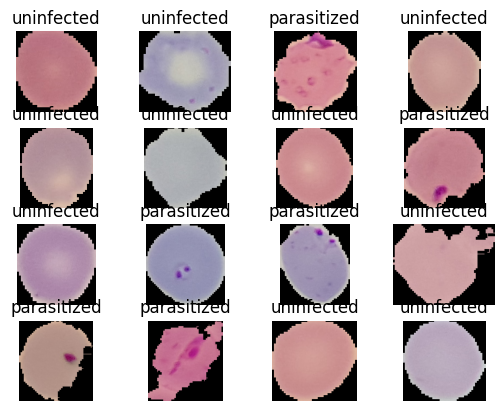

In [6]:
# Visualization 
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [7]:
dataset_info.features['label'].int2str(1) # Encode the labels.

'uninfected'

# Data Preprocessing

In [8]:
# Data Augmentation

In [9]:
def visualize(original, augmented):
    plt.subplot(1,2,1)
    plt.imshow(original)
    plt.subplot(1,2,2)
    plt.imshow(augmented)

In [10]:
original_image, label = next(iter(train_dataset))

In [11]:
augmented_image = tf.image.adjust_saturation(original_image, saturation_factor= 0.3)

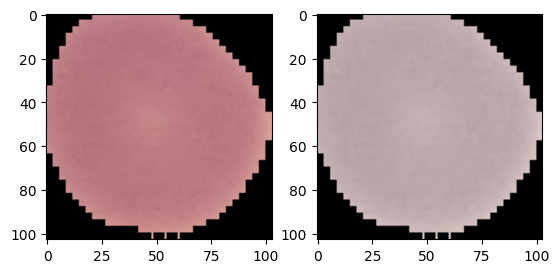

In [12]:
visualize(original_image, augmented_image)

In [13]:
IMAGE_SIZE = 224

In [14]:
@tf.function
def resize_rescale(image, label):
    #print("This code in resize rescale ran")
    #tf.print("This code in the resize rescale with tf.print ran")
    return tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) / 255.0, label

_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [15]:
from tensorflow.keras.layers import Resizing, Rescaling

In [16]:
# tf.keras.layer resizing and rescaling 
resize_rescale_layers = tf.keras.Sequential([
    Resizing(height = IMAGE_SIZE, width = IMAGE_SIZE),
    Rescaling(1. / 255),
])

# Why Resize? - Neural networks typically require input image to have the same size, 224 x 224 is a common size requirement.
# Given an input of 256, 256, 3, it will become -> 224, 224, 3 

# Why Rescale? - This normalizes the pixel values from [0, 255] to [0, 1] by dividing by 255. 
# Neural Networks train faster and more stable when values are small like 0, 1 or -1, 1 

In [17]:
# tf.image augmentation 
@tf.function 
def augment(image, label): 
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    
    return image, label

# Image augmenatation is crucial for robust deep learning models
# Prevents overfitting: introduces "new" images via transformations (helps with small datasets that lead to memorizing)
# Improves generalization: variability simulates real-world data
# Balances Class Distributions: imbalanced dataset may bias the model, helps ease that. 
    

In [18]:
from tensorflow.keras.layers import Layer

In [19]:
# Custom Keras layer: in this case 90-degree rotation to an inputted image. 
class RotNinety(Layer):
    def __init__(self):
        super().__init__()

    @tf.function
    def call(self, image):
        return tf.image.rot90(image)

In [20]:
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast

In [21]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (0.25, 0.2501),),
    RandomFlip(mode='horizontal',),
    RandomContrast(factor=0.1),
])

@tf.function
def augment_layer(image, label): 
    return augment_layers(resize_rescale_layers(image), training = True), label

In [22]:
# Data Loading
BATCH_SIZE = 32

In [23]:
# This applies the resize_rescale function to all of the image-label pair 
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls= tf.data.AUTOTUNE)

In [24]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True) # Randomizes the order, 1024 images at a time. 
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE) # Apply the augmentation to all of the images under optimizations 
    .batch(BATCH_SIZE) # Batches of 32 images 
    .prefetch(tf.data.AUTOTUNE) # Overlaps data preprocessing and model executions
)

In [25]:

val_dataset = (
    val_dataset
    .shuffle(buffer_size = 32)  # Randomizes the order... 
    .map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE) # Applies the resize/rescale function to the val set
    .batch(BATCH_SIZE) # Batches of 32 images 
)

In [26]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [27]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
# Mix Data Augmentation
train_dataset_1 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.shuffle(buffer_size = 4096, ).map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE)
mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [29]:
def mixup(train_dataset_1, train_dataset_2): 
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]
    
    image = lamda * image_1 + (1 - lamda) * image_2
    label = lamda * tf.cast(label_1, dtype = tf.float32) + (1 - lamda) * tf.cast(label_2, dtype = tf.float32)
    return image, label
    

In [30]:
pip install tensorflow_probability


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: /Users/anthonydao/.venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install 'tensorflow-probability[tf]'

  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 1.5 MB/s eta 0:00:0000:0100:05
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 2.9 MB/s eta 0:00:00a 0:00:01
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attem

In [35]:
pip show tensorflow

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/anthonydao/.venv/lib/python3.12/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: tf_keras
Note: you may need to restart the kernel to use updated packages.


In [34]:
import tensorflow_probability as tfp

ImportError: This version of TensorFlow Probability requires TensorFlow version >= 2.18; Detected an installation of version 2.16.1. Please upgrade TensorFlow to proceed.

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size = 4096, reshuffle_each_iteration = True)
    .map(mixup, num_parallel_calls= tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
    
)

In [ ]:
train_dataset